In [8]:
import numpy as np
import matplotlib.pyplot as py

In [9]:
grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

In [10]:
V0 = 0.38
k = 4/3
def vectorfeld(phi, H, V = lambda x: V0*x**k):
    if 3*H**2 - V(phi) > 0:
        phiprime = -2*grad_calc(H, V0, phi, k)
        hprime = -2*((grad_calc(H, V0, phi, k))**2)
    else:
        phiprime = 0
        hprime = 0
    return phiprime, hprime

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -3.84704062,
        -4.61299485, -5.3141059 ],
       [ 0.        ,  0.        ,  0.        , ..., -3.69173211,
        -4.48429325, -5.20277676],
       [ 0.        ,  0.        ,  0.        , ..., -3.527773  ,
        -4.35030831, -5.08774826]])

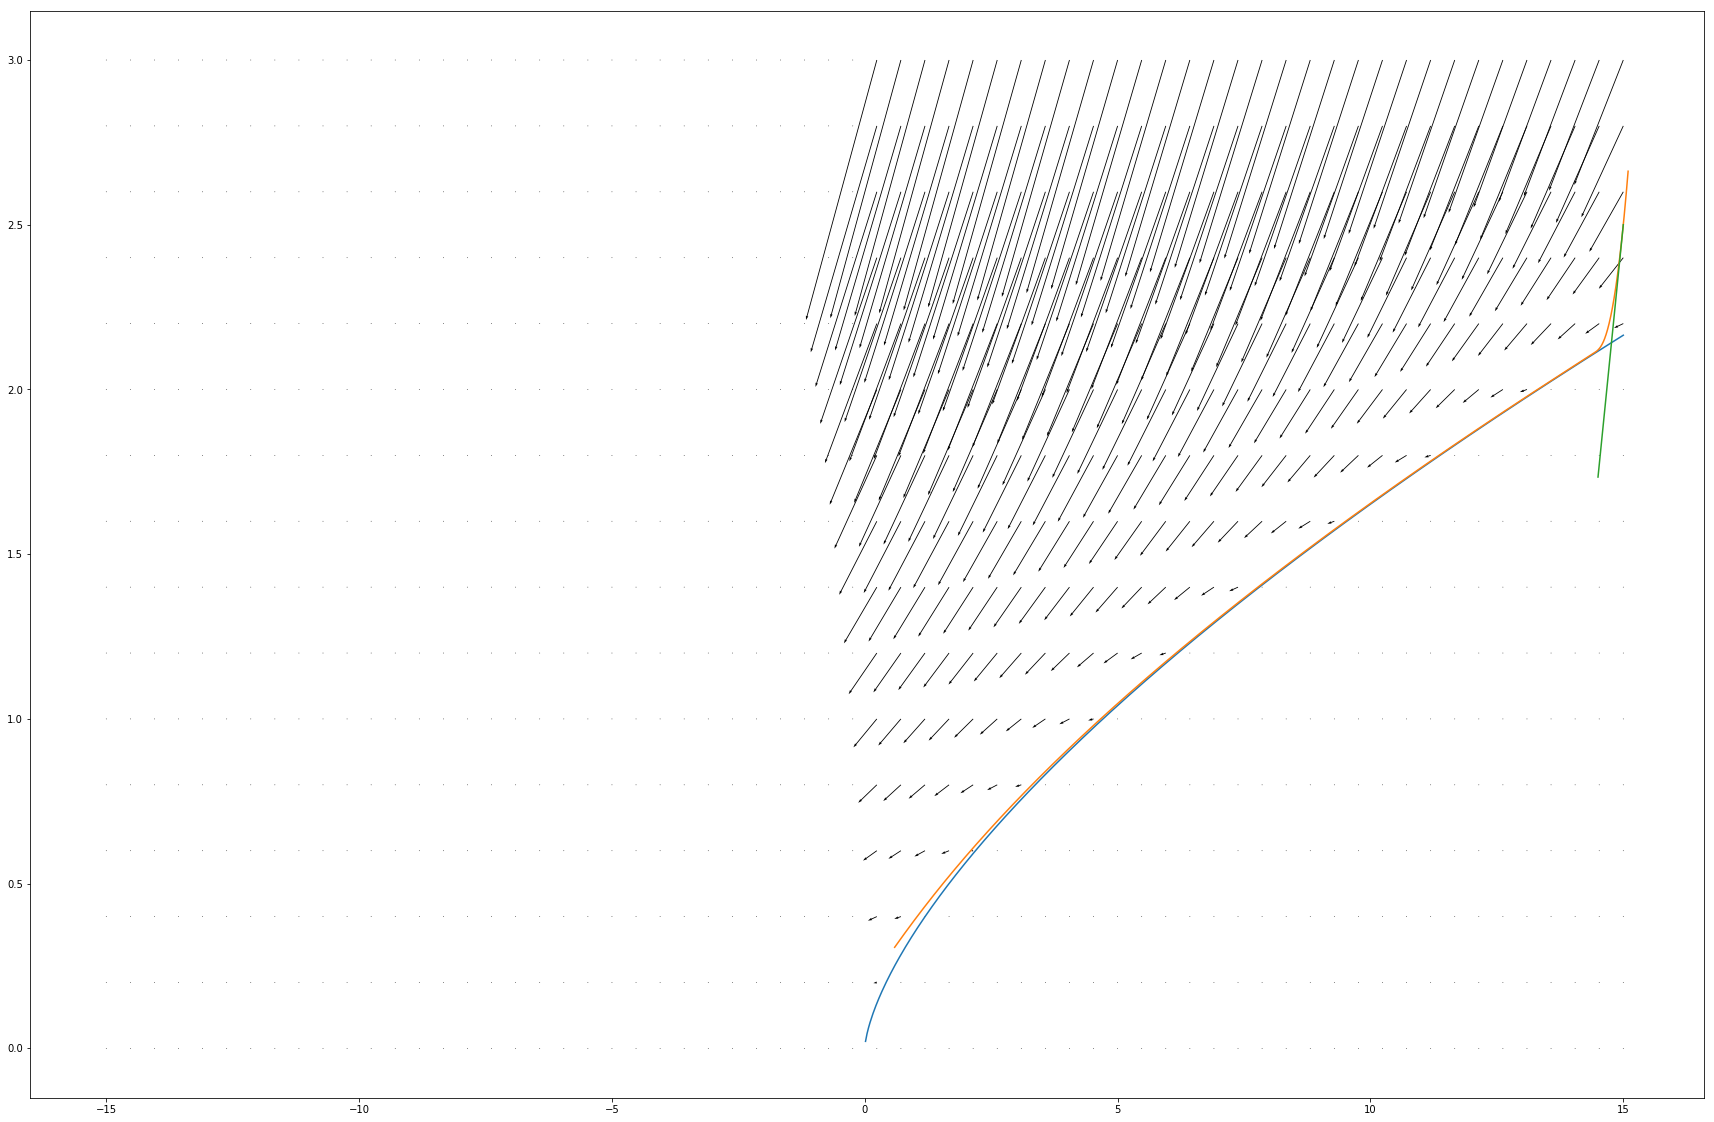

In [11]:
xbound = 15
ybound = 3
nx, ny = 64, 16
x = np.linspace(-1*xbound, xbound, nx)
y = np.linspace(0, ybound, ny)

phidotarray = np.zeros((nx, ny))
Hdotarray = np.zeros((nx, ny))
for i, xn in enumerate(x):
    for j, yn in enumerate(y):
        phidotarray[i, j] = vectorfeld(xn, yn)[0]

for i, xn in enumerate(x):
    for j, yn in enumerate(y):
        Hdotarray[i, j] = vectorfeld(xn, yn)[1]
        
py.figure(figsize=(30, 20)) 
py.quiver(x, y, np.transpose(phidotarray), np.transpose(Hdotarray), width = 0.0005)
potential = lambda x: V0*x**k
potsqrt = [(potential(ins)/3)**0.5 for ins in np.linspace(-xbound, xbound, 1024)]
py.plot(np.linspace(-xbound, xbound, 1024), potsqrt)

grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

def trajectory(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N[n] < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1]

phi, H, ___, __, _ = tot_traj(90, V0, k, phi_0 = 15, suppress = False, epsilonstop = True)
py.plot(phi, H)

py.plot(np.array([15, 15 - 0.5]), np.array([2.5, 2.5 - 0.5*grad_calc(2.5, V0, 15, k)]))
phidotarray

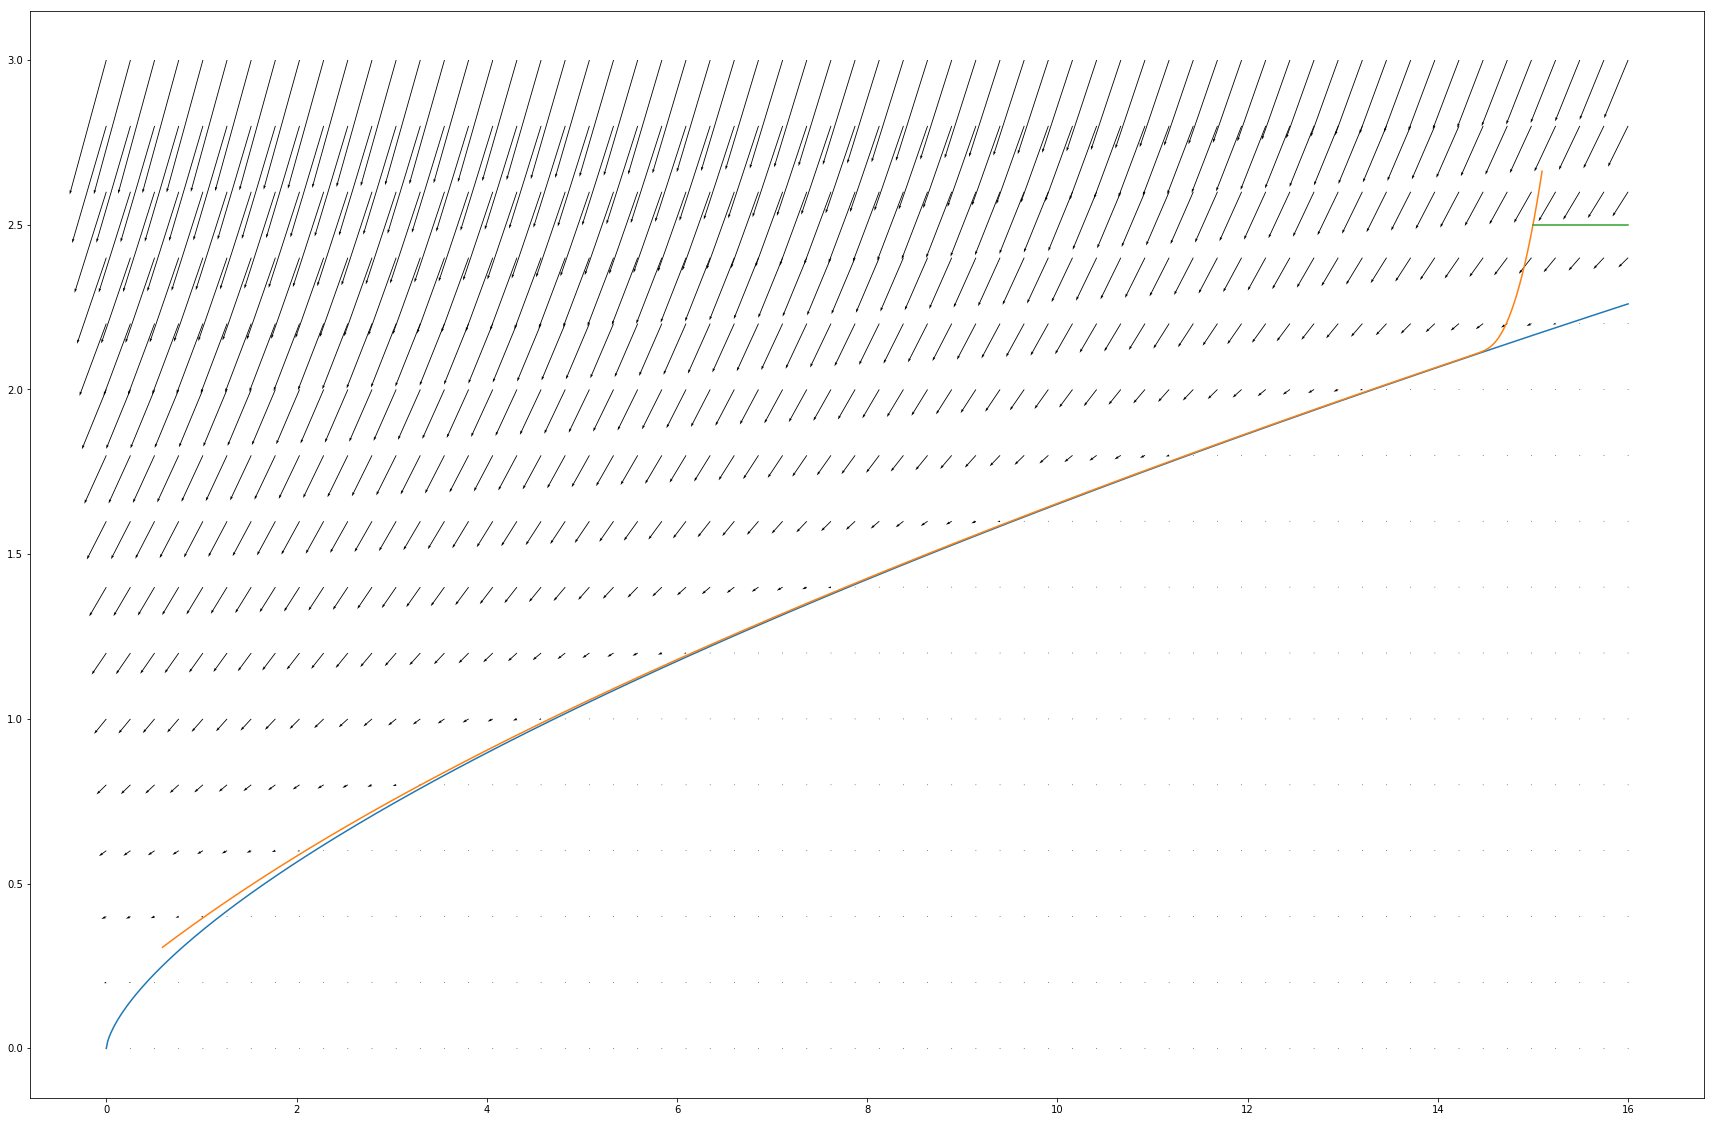

In [12]:
xbound = 16
ybound = 3
nx, ny = 64, 16
x = np.linspace(0, xbound, nx)
y = np.linspace(0, ybound, ny)

phidotarray = np.zeros((nx, ny))
Hdotarray = np.zeros((nx, ny))
for i, xn in enumerate(x):
    for j, yn in enumerate(y):
        phidotarray[i, j] = vectorfeld(xn, yn)[0]

for i, xn in enumerate(x):
    for j, yn in enumerate(y):
        Hdotarray[i, j] = vectorfeld(xn, yn)[1]
        
py.figure(figsize=(30, 20)) 
py.quiver(x, y, np.transpose(phidotarray), np.transpose(Hdotarray), width = 0.0005)
potential = lambda x: V0*x**k
potsqrt = [(potential(ins)/3)**0.5 for ins in np.linspace(0, xbound, 1024)]
py.plot(np.linspace(0, xbound, 1024), potsqrt)

grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

def trajectory(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N[n] < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1]

phi, H, ___, __, _ = tot_traj(90, V0, k, phi_0 = 15, suppress = False, epsilonstop = True)
py.plot(phi, H)

py.plot(np.linspace(15, 16, 5), 2.5*np.ones(5))

<Figure size 432x288 with 0 Axes>

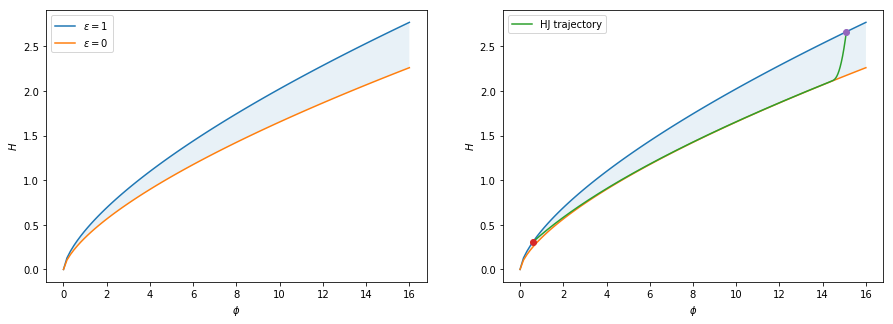

<Figure size 432x288 with 0 Axes>

In [17]:
#here I will illustrate the domain
Hline = np.linspace(0, 9, 101)
philine = np.linspace(0, 16, 101)
Hmesh, phimesh = np.meshgrid(Hline, philine)

dom_fig, domax = py.subplots(1,2, figsize = (15, 5))
domax[0].plot(philine, [np.sqrt(0.5*V0*(p**k)) for p in philine], label = '$ε = 1$')
domax[0].plot(philine, [np.sqrt((1/3)*V0*(p**k)) for p in philine], label = '$ε = 0$')
domax[0].fill_between(philine, [np.sqrt((1/3)*V0*(p**k)) for p in philine], [np.sqrt(0.5*V0*(p**k)) for p in philine], alpha = 0.1)
domax[0].set(xlabel = '$\phi$', ylabel = '$H$')
domax[0].legend()

domax[1].plot(philine, [np.sqrt(0.5*V0*(p**k)) for p in philine])
domax[1].plot(philine, [np.sqrt((1/3)*V0*(p**k)) for p in philine])
domax[1].fill_between(philine, [np.sqrt((1/3)*V0*(p**k)) for p in philine], [np.sqrt(0.5*V0*(p**k)) for p in philine], alpha = 0.1)
domax[1].set(xlabel = '$\phi$', ylabel = '$H$')
domax[1].plot(phi, H, label = 'HJ trajectory')
domax[1].plot(phi[0], H[0], 'o')
domax[1].plot(phi[-1], H[-1], 'o')
domax[1].legend()

py.figure()

In [18]:
dom_fig.savefig('deff.png')